In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
%config IPCompleter.use_jedi = False

In [5]:
fname = 'dataset.npz'
with np.load(fname) as data:
    designs = data['D']
    responses = data['R']
    
n_grating_layers = designs.shape[-1]
n_freqs = responses.shape[-1]
Dtrain, Dtest, Rtrain, Rtest = train_test_split(designs, responses,
                                                test_size=0.1,
                                                random_state=42)
print("Train set contains {} samples".format(Dtrain.shape[0]))
print("Validation set contains {} samples".format(Dtest.shape[0]))

Train set contains 588429 samples
Validation set contains 65381 samples


In [6]:
activation = keras.activations.sigmoid
# Architecture 4
model = keras.Sequential([layers.Input((n_grating_layers,), name='D'),
                          layers.Dense(500, activation=activation, name='F1'),
                          layers.Dense(200, activation=activation, name='F2'),
                          layers.Dense(200, activation=activation, name='F3'),
                          layers.Dense(200, activation=activation, name='F4'),
                          layers.Dense(n_freqs, activation='sigmoid', name='R')],
                         name='ForwardNet')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
F2 (Dense)                   (None, 500)               8000      
_________________________________________________________________
F3 (Dense)                   (None, 200)               100200    
_________________________________________________________________
F4 (Dense)                   (None, 200)               40200     
_________________________________________________________________
F5 (Dense)                   (None, 200)               40200     
_________________________________________________________________
F6 (Dense)                   (None, 200)               40200     
Total params: 228,800
Trainable params: 228,800
Non-trainable params: 0
_________________________________________________________________


In [8]:
def loss(y_true, y_pred):
    return n_freqs * keras.losses.mse(y_true, y_pred)

model.compile(loss=loss, optimizer='adam')

In [9]:
initial_epoch = 0

In [10]:
info = model.fit(Dtrain, Rtrain,
                 batch_size=128, epochs=4000,
                 validation_data=(Dtest, Rtest),
                 validation_freq=5,
                 initial_epoch=initial_epoch)
initial_epoch = info.epoch[-1]

Epoch 1/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 7.6367
Epoch 2/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 7.5111
Epoch 3/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 7.4782
Epoch 4/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 7.4112
Epoch 5/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 7.2431 - val_loss: 7.1776
Epoch 6/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 7.0169
Epoch 7/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 6.9018
Epoch 8/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 6.8506
Epoch 9/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 6.7844
Epoch 10/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 6.6476 - val_loss: 6.5328
Epoch 11/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 6.4414
Epoch 12/1000
4598/4598

4598/4598 [==============================] - 9s 2ms/step - loss: 2.2910
Epoch 92/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.2762
Epoch 93/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.2592
Epoch 94/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.2432
Epoch 95/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 2.2293 - val_loss: 2.3105
Epoch 96/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.2143
Epoch 97/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.1996
Epoch 98/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.1860
Epoch 99/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.1725
Epoch 100/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 2.1588 - val_loss: 2.2497
Epoch 101/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 2.1451
Epoch 102/1000
4598/4598 [

4598/4598 [==============================] - 9s 2ms/step - loss: 1.5401
Epoch 182/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.5362
Epoch 183/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.5318
Epoch 184/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.5280
Epoch 185/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.5229 - val_loss: 1.5926
Epoch 186/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.5194
Epoch 187/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.5142
Epoch 188/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.5101
Epoch 189/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.5066
Epoch 190/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.5019 - val_loss: 1.5978
Epoch 191/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.4977
Epoch 192/1000
459

4598/4598 [==============================] - 9s 2ms/step - loss: 1.2527
Epoch 272/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2504
Epoch 273/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2483
Epoch 274/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2460
Epoch 275/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.2442 - val_loss: 1.3161
Epoch 276/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2416
Epoch 277/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2398
Epoch 278/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2376
Epoch 279/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2358
Epoch 280/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.2327 - val_loss: 1.2951
Epoch 281/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.2310
Epoch 282/1000
459

Epoch 361/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.1000
Epoch 362/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.0989
Epoch 363/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.0974
Epoch 364/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.0966
Epoch 365/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.0946 - val_loss: 1.1725
Epoch 366/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.0938
Epoch 367/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.0923
Epoch 368/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.0911
Epoch 369/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.0904
Epoch 370/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 1.0886 - val_loss: 1.1721
Epoch 371/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 1.0873
E

Epoch 451/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9964
Epoch 452/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9956
Epoch 453/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9944
Epoch 454/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9942
Epoch 455/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9925 - val_loss: 1.0507
Epoch 456/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9914
Epoch 457/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9906
Epoch 458/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9903
Epoch 459/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9890
Epoch 460/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9882 - val_loss: 1.0556
Epoch 461/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9868


4598/4598 [==============================] - 10s 2ms/step - loss: 0.9203 - val_loss: 0.9834
Epoch 541/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9189
Epoch 542/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9182
Epoch 543/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9177
Epoch 544/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9163
Epoch 545/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9162 - val_loss: 0.9773
Epoch 546/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9148
Epoch 547/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.9144
Epoch 548/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9138
Epoch 549/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9127
Epoch 550/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.9127 - val_loss: 0.

4598/4598 [==============================] - 9s 2ms/step - loss: 0.8610
Epoch 630/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.8608 - val_loss: 0.9117
Epoch 631/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8601
Epoch 632/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8596
Epoch 633/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8588
Epoch 634/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8583
Epoch 635/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.8580 - val_loss: 0.9229
Epoch 636/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8571
Epoch 637/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8566
Epoch 638/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.8565
Epoch 639/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.8562
Epoch 640/1000
4

Epoch 719/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8156
Epoch 720/1000
4598/4598 [==============================] - 12s 3ms/step - loss: 0.8155 - val_loss: 0.8933
Epoch 721/1000
4598/4598 [==============================] - 17s 4ms/step - loss: 0.8142
Epoch 722/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8145
Epoch 723/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8139
Epoch 724/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8133
Epoch 725/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8132 - val_loss: 0.8586
Epoch 726/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8125
Epoch 727/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8120
Epoch 728/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8117
Epoch 729/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.8110
Epo

4598/4598 [==============================] - 9s 2ms/step - loss: 0.7807
Epoch 809/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7795
Epoch 810/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7794 - val_loss: 0.8512
Epoch 811/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7794
Epoch 812/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7793
Epoch 813/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7787
Epoch 814/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7778
Epoch 815/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7781 - val_loss: 0.8540
Epoch 816/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7773
Epoch 817/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7768
Epoch 818/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7771
Epoch 819/1000
4598

4598/4598 [==============================] - 9s 2ms/step - loss: 0.7514
Epoch 899/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7511
Epoch 900/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7507 - val_loss: 0.8015
Epoch 901/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7504
Epoch 902/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7506
Epoch 903/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7500
Epoch 904/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7499
Epoch 905/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7494 - val_loss: 0.8002
Epoch 906/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7487
Epoch 907/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7485
Epoch 908/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7482
Epoch 909/1000
4598/

4598/4598 [==============================] - 10s 2ms/step - loss: 0.7259
Epoch 988/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7255
Epoch 989/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7255
Epoch 990/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7251 - val_loss: 0.7722
Epoch 991/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7246
Epoch 992/1000
4598/4598 [==============================] - 9s 2ms/step - loss: 0.7241
Epoch 993/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7247
Epoch 994/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7242
Epoch 995/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7236 - val_loss: 0.7605
Epoch 996/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7232
Epoch 997/1000
4598/4598 [==============================] - 10s 2ms/step - loss: 0.7229
Epoch 998/1

In [12]:
epochs = model.history.epoch[-1] + 1
model.save(
    os.path.join('forward_model',
                 'Arch4_Epochs{}_Adam0001_Sigmoid.h5'.format(epochs)))

Text(0.5, 0, 'Epoch')

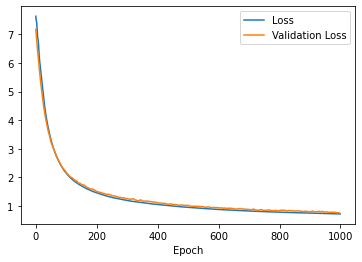

In [13]:
val_loss = model.history.history['val_loss']
loss = model.history.history['loss']
fig, ax = plt.subplots()
ax.plot(info.epoch, loss, label='Loss')
ax.plot(info.epoch[::5], val_loss, label='Validation Loss')
ax.legend()
ax.set_xlabel('Epoch')

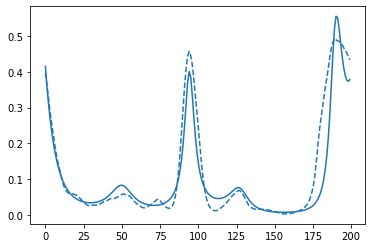

In [15]:
idx = np.random.randint(0, Dtest.shape[0], 1)
dnn_responses = model(Dtest[idx]).numpy()
responses = Rtest[idx]
for o, r in zip(dnn_responses, responses):
    line, = plt.plot(o, '--')
    plt.plot(r, '-', color=line.get_color())